In [1]:
from fastbook import doc

In [24]:
from fastbook import search_images_ddg, download_url

ims = search_images_ddg('grizzly bear', 150)
print(ims[0])

images_root = 'images'
dest = f'{images_root}/tmp/grizzly.jpg'
download_url(ims[0], dest)

http://4.bp.blogspot.com/-KliQsenmXqs/Un_rUjF4fII/AAAAAAAABUk/MAbB7TAbOrY/s1600/Grizzly_Bears.jpg


Path('images/tmp/grizzly.jpg')

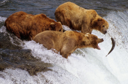

In [4]:
from fastai.vision.core import Image

im = Image.open(dest)
im.to_thumb(128, 128)

In [5]:
from fastbook import Path

bear_types = 'grizzly','black','teddy'
path = Path(f'{images_root}/bears')

In [6]:
%%time

from fastai.vision.utils import download_images

if not path.exists():
    path.mkdir(parents=True)
    for o in bear_types:
        print(f"downloading images: {o}")
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', 150)
        download_images(dest, urls=results)

CPU times: user 53 µs, sys: 36 µs, total: 89 µs
Wall time: 84.2 µs


In [7]:
# Delete broken images

from fastai.vision.utils import verify_images
from fastai.data.transforms import get_image_files

fns = get_image_files(path)

failed = verify_images(fns)
if len(failed) > 0:
    failed.map(Path.unlink)
    print(f'Removed {len(failed)} corrupted images')

In [8]:
# Delete images with transparency channel

import os
from fastcore.foundation import L 

def verify_no_alpha(image_files):
    alpha_image_paths = L()
    modes = {}
    for file in image_files:
        try:
            with Image.open(file) as img:
                if img.mode not in modes:
                    modes[img.mode] = 0
                modes[img.mode] += 1
                
                if img.mode in ('RGBA', 'P'):
                    print(f'alpha channel {file}')
                    alpha_image_paths.append(file)
                elif not img.format == 'JPEG':
                    print(f'not jpeg format {file}')
                    alpha_image_paths.append(file)
                elif not file.name.lower().endswith(('.jpg', '.jpeg')):
                    printf(f'not .jpg or .jpeg')
                    alpha_image_paths.append(file)
        except Exception as e:
            print(f'Error processing {entry} : {path} : {e}')
    return alpha_image_paths, modes

fns = get_image_files(path)
alpha, modes = verify_no_alpha(fns)
print(modes)
if len(alpha) > 0:
    alpha.map(Path.unlink)
    print(f'Removed {len(alpha)} images with alpha channel')

{'RGB': 379}


In [9]:
from fastai.data.block import DataBlock, CategoryBlock
from fastai.vision.data import ImageBlock
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.vision.augment import Resize

bears = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

/Users/aizotov/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


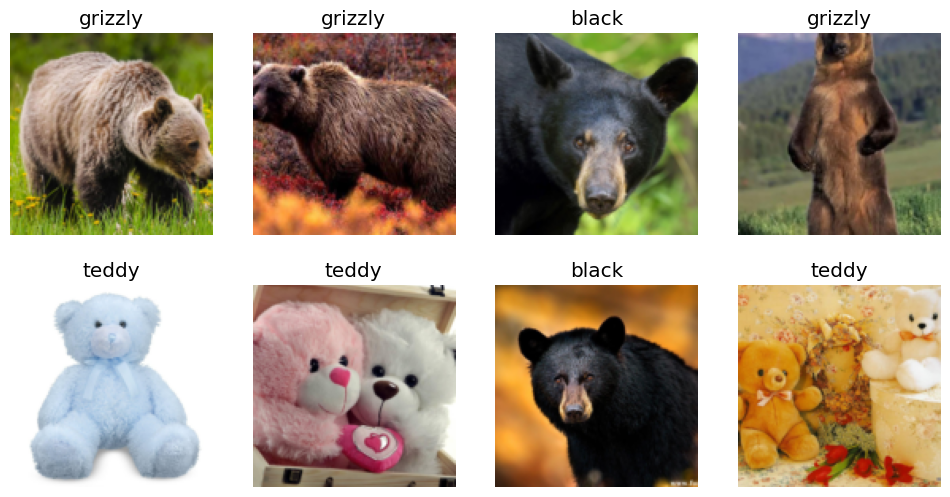

In [10]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8)

## Testing different resize methods

In [11]:
from fastbook import ResizeMethod

# bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
# dls = bears.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

In [12]:
# bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
# dls = bears.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

## Data Augmentation

In [27]:
from fastai.vision.augment import RandomResizedCrop

# "...what we normally do in practice is to randomly select part of the image, and crop to just that part"

# bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
# dls = bears.dataloaders(path)
# dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [14]:
# TODO change deities classifier to use data augmentation - RandomResizedCrop and/or aug_transforms

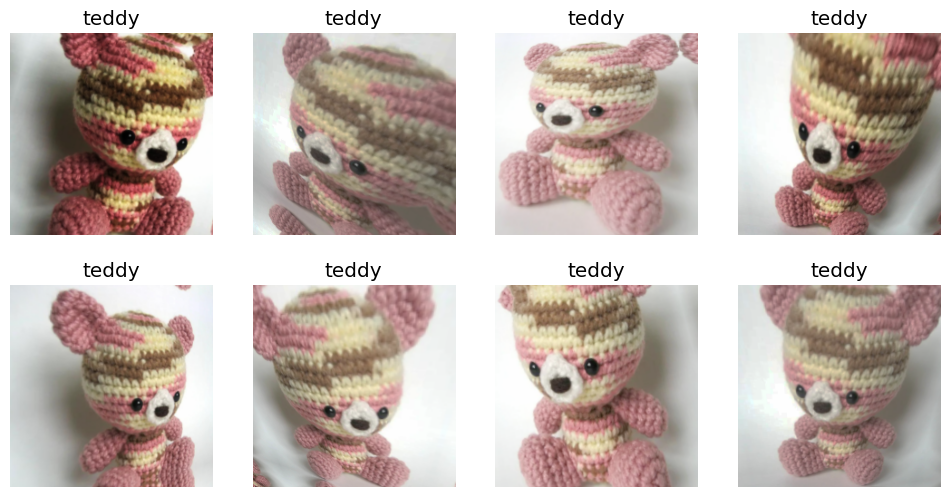

In [28]:
from fastai.vision.augment import aug_transforms

bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
# time to train model!

bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [37]:
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet18
from fastai.metrics import error_rate

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.940616,0.115047,0.026667,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.508968,0.074910,0.026667,00:06
1,0.413356,0.056497,0.013333,00:06
2,0.346084,0.050697,0.013333,00:06
3,0.286992,0.048689,0.013333,00:06


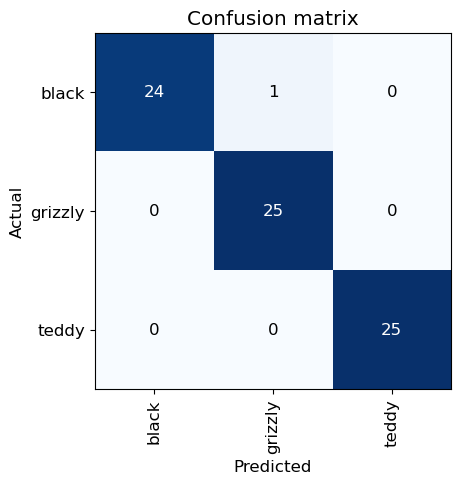

In [38]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

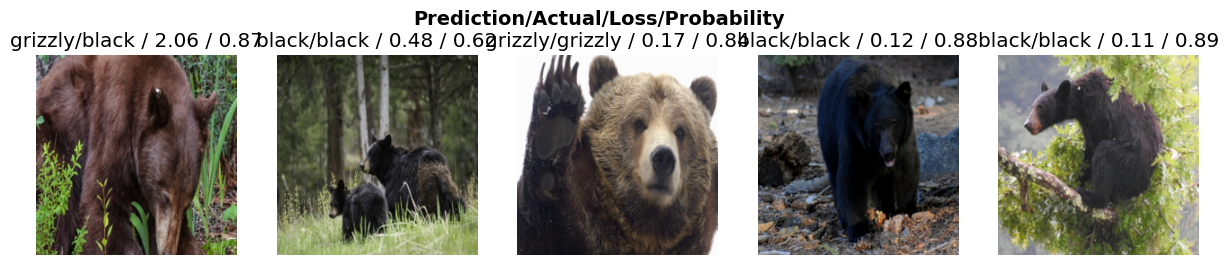

In [19]:
interp.plot_top_losses(5, nrows=1)


In [20]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner